In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm

In [2]:
%matplotlib inline

### Lecture des bases de données

In [3]:
country = pd.read_csv("./data/EdStatsCountry.csv")
data = pd.read_csv("./data/EdStatsData.csv")
series = pd.read_csv("./data/EdStatsSeries.csv")

## I) Introduction et nettoyage préliminaire   
On va utiliser 3 des bases de données disponibles:
- **series**: Pour accéder aux informations sur les indicateurs.
- **data**: Pour accéder aux mesures par pays pour les indicateurs.
- **country**: Pour connaître la région des pays étudiés.

### I) 1- Series

In [4]:
series = series.drop(columns=['Unnamed: 20'])  # Colonne inutile

In [5]:
print("Nombre de colonnes: %d" % len(series.columns))
print("Nombre de doublons: %d" % (len(series)-len(series.drop_duplicates())))
print("Nombre de lignes vides: %d" % (len(series)-series.count()['Series Code']))
print("Nombre de lignes = Nombre d'indicateurs: %d" % len(series))

Nombre de colonnes: 20
Nombre de doublons: 0
Nombre de lignes vides: 0
Nombre de lignes = Nombre d'indicateurs: 3665


In [6]:
series['Indicator Name'] = series['Indicator Name'].str.lower()  # Correspond à 'Indicator Name' dans data
series['Series Code'] = series['Series Code'].str.upper()  # Correspond à 'Indicator Code' dans data

### I) 2- data

In [7]:
data['Indicator Code'] = data['Indicator Code'].str.upper()
data['Indicator Name'] = data['Indicator Name'].str.lower()
data = data.drop(columns=['Unnamed: 69'])  # Colonne inutile

In [8]:
print("Nombre de colonnes: %d" % len(data.columns))
print("Nombre de doublons: %d" % (len(data)-len(data.drop_duplicates(subset=['Country Code', 'Indicator Code']))))
print("Nombre de lignes = Nombre de mesures: %d" % len(data))

Nombre de colonnes: 69
Nombre de doublons: 0
Nombre de lignes = Nombre de mesures: 886930


Pour les valeurs manquantes, on s'intéressera uniquement aux indicateurs statistiques sélectionnés, plus loin dans l'analyse.

### I) 3- country

In [9]:
country = country.drop(columns=['Unnamed: 31'])  # Colonne inutile

In [10]:
print("Nombre de colonnes: %d" % len(country.columns))
print("Nombre de doublons: %d" % (len(country)-len(country.drop_duplicates(subset=['Country Code']))))
print("Nombre de lignes vides: %d" % (len(country)-country.count()['Country Code']))
print("Nombre de lignes = Nombre de pays: %d" % len(country))

Nombre de colonnes: 31
Nombre de doublons: 0
Nombre de lignes vides: 0
Nombre de lignes = Nombre de pays: 241


## Période étudiée
On s'intéresse aux années récentes, datant d'après 2004. On ne prendra pas les données après 2014 car elles sont trop rares, même pour les indicateurs les plus communs.

In [11]:
# years: Index contenant toutes les années disponibles
years = data.columns[data.columns.str.contains("[12][019][0-9][0-9]")]
int_years = years.map(int)  # Cast des années en valeurs entières pour en extraire des tranches
# years_in: Index contenant les années étudiées (entre 2004 et 2014)
years_in = int_years[(int_years >= 2004) & (int_years <= 2014)]
# years_rec: Index contenant toutes les années récentes disponibles (entre 2004 et 2020)
years_rec = int_years[(int_years >= 2004) & (int_years <= 2020)]
# years_proj: Index contenant toutes les années futures (après 2020)
years_proj = int_years[int_years > 2020]
# Cast des valeurs des index en str, pour correspondre aux colonnes des dataframes:
years_in = years_in.map(str)
years_rec = years_rec.map(str)
years_proj = years_proj.map(str)
# years_out: Index contenant les années non-étudiées
years_out = years[~years.isin(years_in)]
print("Années étudiées:\n%s" % years_in)

Années étudiées:
Index(['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014'],
      dtype='object')


## II) Sélection des indicateurs statistiques
On choisit les indicateurs suivants pour discriminer les pays:
- Taux de scolarisation au secondaire
- Le PIB/hab du pays
- Accès à une bonne connection internet
- Démographie chez la population jeune (15-25 ans) en pourcentage de la population totale

### Recherche des indicateurs dans la dataframe series

On veut savoir quelle quantité de données on a pour chaque indicateur. On va donc ajouter une colonne dans series qui contiendra la taille moyenne de l'échantillon par année pour les années étudiées.

In [12]:
# index: Index contenant les colonnes des années étudiées et le code indicateur
index = years_in.append(pd.Index(['Indicator Code']))
# indic_mean: Va contenir le nombre moyen de pays dont on a la valeur par indicateur. La moyenne est calculée sur
# les années étudiées.
indic_mean = data[index].groupby('Indicator Code').count().mean(axis=1)
indic_mean = indic_mean.rename("Mean sample size")
indic_mean = indic_mean.to_frame()
# On ajoute la colonne 'Mean sample size' à series, pour ajouter cette donnée pour choisir les indicateurs.
series = pd.merge(series, indic_mean, right_index=True, left_on='Series Code')  # Ajout de la colonne créée à series

### II) 1- Taux de scolarisation

In [13]:
# indics_educ: Va contenir les lignes de series dont les indicateurs contiennent les mots clés intéressants. 
indics_educ = series
indics_educ = indics_educ[indics_educ['Indicator Name'].str.contains('upper secondary')]
indics_educ = indics_educ[indics_educ['Indicator Name'].str.contains('enrolment ratio')]
indics_educ = indics_educ[indics_educ['Indicator Name'].str.contains('both sexes')]
#print("Indicateurs potentiels:\n%s\n" \
#      % indics_educ[['Indicator Name', 'Mean sample size']].sort_values('Mean sample size', ascending=False))
# indic_educ: Ligne de series qui contient l'indicateur choisi
indic_educ = indics_educ.loc[2313]
print("Indicateur choisi:\n%s" % indic_educ[['Indicator Name', 'Mean sample size']])

Indicateur choisi:
Indicator Name      gross enrolment ratio, upper secondary, both s...
Mean sample size                                           170.636364
Name: 2313, dtype: object


### II) 2- PIB

In [14]:
# indics_pib: Va contenir les lignes de series dont les indicateurs contiennent les mots clés intéressants.
indics_pib = series[series['Indicator Name'].str.contains('gdp')]  # gdp: Gross Domestic Product 
#print("Indicateurs potentiels:\n%s" \
#      % indics_pib[['Indicator Name', 'Mean sample size']].sort_values('Mean sample size', ascending=False))
# indic_pib: Ligne de series qui contient l'indicateur choisi
indic_pib = series.loc[1662]
print("Indicateur choisi:\n%s" % indic_pib[['Indicator Name', 'Mean sample size']])

Indicateur choisi:
Indicator Name      gdp per capita (current us$)
Mean sample size                      226.909091
Name: 1662, dtype: object


### II) 3- Accès à une connexion internet

In [15]:
# indics_internet: Va contenir les lignes de series dont les indicateurs contiennent les mots clés intéressants.
indics_internet = series[series['Indicator Name'].str.contains('internet')]
#print("Indicateurs potentiels:\n%s" % \
#      indics_internet[['Indicator Name', 'Mean sample size']].sort_values('Mean sample size', ascending=False))
# indic_internet: Ligne de series qui contient l'indicateur choisi
indic_internet = series.loc[611]
print("Indicateur internet choisi:\n%s" % indic_internet[['Indicator Name', 'Mean sample size']])

Indicateur internet choisi:
Indicator Name      internet users (per 100 people)
Mean sample size                         225.636364
Name: 611, dtype: object


### II) 4- Démographie chez les jeunes   

In [16]:
# indics_demog: Va contenir les lignes de series dont les indicateurs contiennent les mots clés intéressants.
indics_demog = series[series['Indicator Name'].str.contains('population')]
indics_demog = indics_demog[indics_demog['Indicator Name'].str.contains('ages')]
indics_demog = indics_demog[indics_demog['Indicator Name'].str.contains('15-24')]
#print("Indicateurs potentiels:\n%s" \
#      % indics_demog[['Indicator Name', 'Mean sample size']].sort_values('Mean sample size', ascending=False))
# indic_pop_jeune: Ligne de series qui contient l'indicateur choisi
indic_pop_jeune = indics_demog.loc[2506]
print("Indicateur population jeune choisi:\n%s" % indic_pop_jeune[['Indicator Name', 'Mean sample size']])

Indicateur population jeune choisi:
Indicator Name      population, ages 15-24, total
Mean sample size                       183.363636
Name: 2506, dtype: object


In [17]:
# indics_demog: Va contenir les lignes de series dont les indicateurs contiennent les mots clés intéressants.
indics_demog = series[series['Indicator Name'].str.contains('population, total')]
#print("Indicateurs potentiels:\n%s" % indics_demog['Indicator Name'])
# indic_pop_tot: Ligne de series qui contient l'indicateur choisi
indic_pop_tot = indics_demog.loc[2590]
print("Indicateur population totale choisi:\n%s" % indic_pop_tot[['Indicator Name', 'Mean sample size']])

Indicateur population totale choisi:
Indicator Name      population, total
Mean sample size           239.090909
Name: 2590, dtype: object


## III) Qualité des données des indicateurs et calcul du score

### III) 1- Scolarisation

In [18]:
# data_educ: Dataframe qui va contenir les données de l'indicateur de scolarisation pour les pays étudiés
data_educ = data[data['Indicator Code'] == indic_educ['Series Code']]

Valeurs manquantes:

<AxesSubplot: >

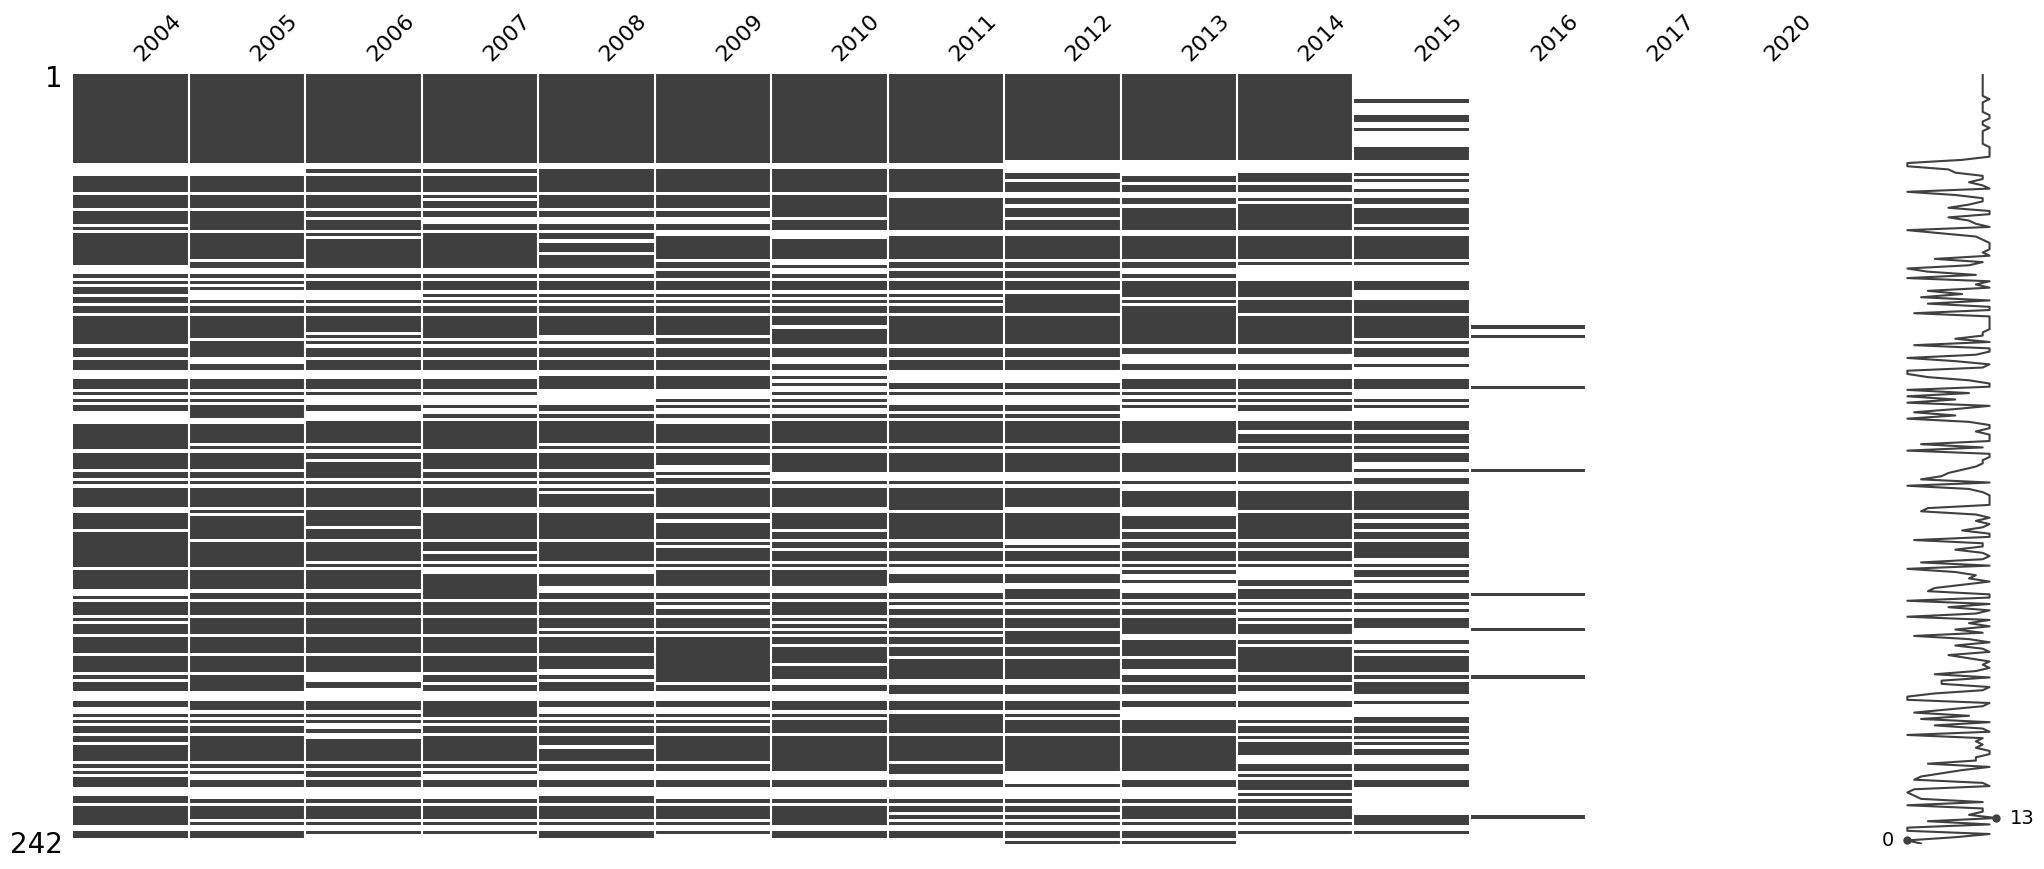

In [19]:
msno.matrix(data_educ[years_rec])

Text(0, 0.5, 'Année')

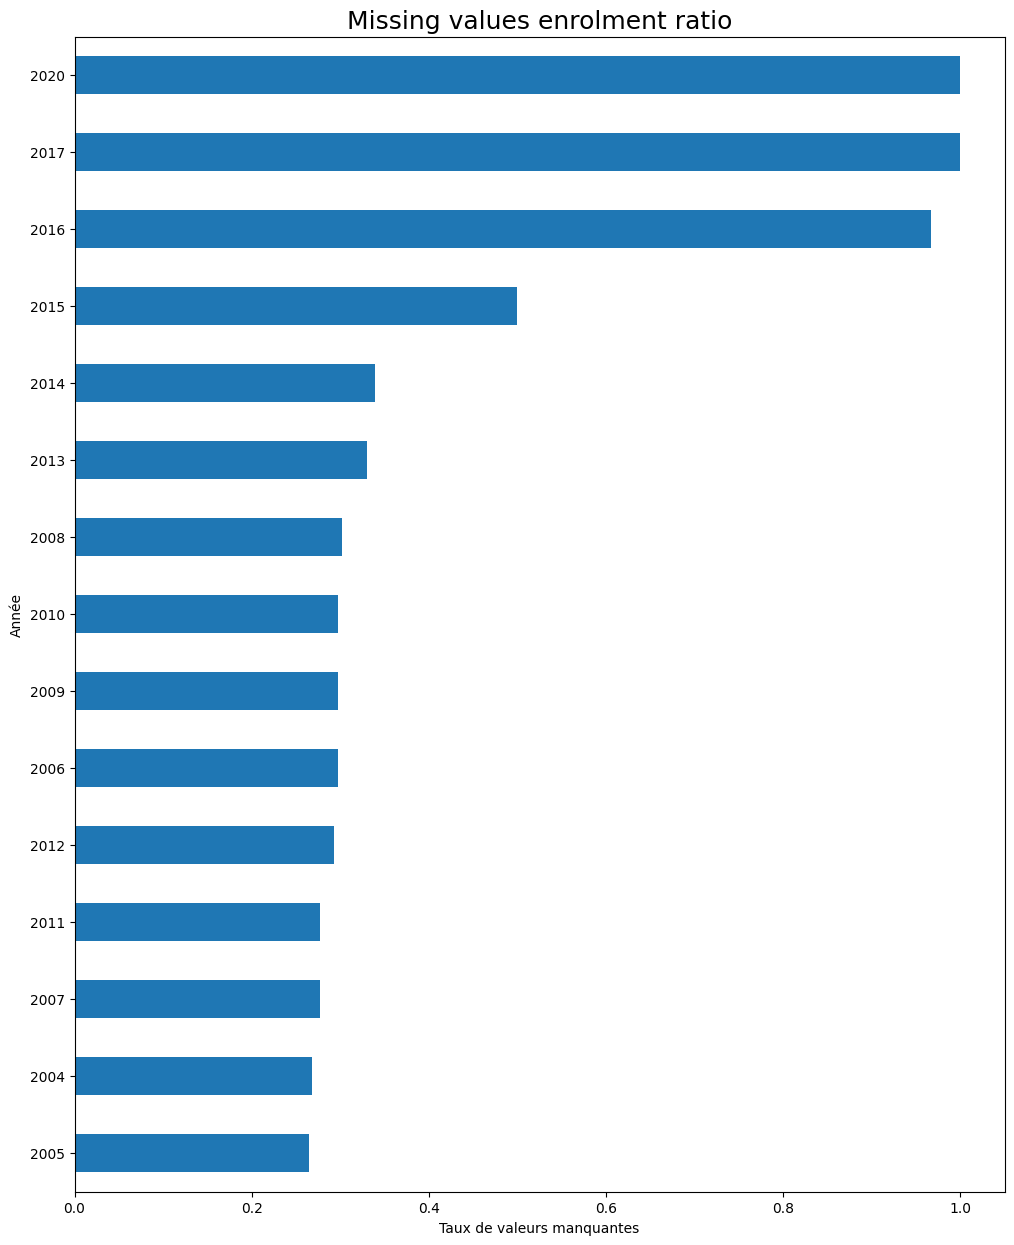

In [20]:
fig = plt.figure(figsize=[12,15])
data_educ[years_rec].isnull().mean(axis=0).sort_values().plot.barh()
plt.rc('font', size=16)
plt.title('Missing values enrolment ratio', fontsize=18)
plt.xlabel('Taux de valeurs manquantes')
plt.ylabel('Année')

On supprime les colonnes des années non étudiées:

In [21]:
data_educ = data_educ.drop(columns=years_out)

In [22]:
# On supprime les pays avec moins de 80% des années remplies
data_educ = data_educ[data_educ[years_in].count(axis=1) >= int(0.8*len(years_in))]
print("Taille de l'échantillon pour l'indicateur du taux de scolarisation: %d" % len(data_educ))

Taille de l'échantillon pour l'indicateur du taux de scolarisation: 159


On vérifie qu'il n'y à pas de valeurs aberrantes

In [23]:
def is_float_pos(x):
    """Détecte les non-flottants (non-nan) et les flottants négatifs"""
    res = (isinstance(x, float) and x>=0) or np.isnan(x)
    if not res:
        print("Valeur erronnée:%s (type=%s)" %(x, res))
        return res
    else:
        return res
def is_float_s(s):
    """Applique is_float_pos à une série"""
    return s.map(is_float_pos)

Repèrage des valeurs non-flotantes ou négatives.

In [24]:
data_educ_wrong = data_educ[years_in].apply(is_float_s)

In [25]:
# Calcul des maximums/minimums pour chaque ligne:
data_educ_max, data_educ_min = data_educ[years_in].max(), data_educ[years_in].min()
print("Taux de scolarisation dans [%s, %s]" %(min(data_educ_min), max(data_educ_max)))

Taux de scolarisation dans [3.393630027771, 224.360305786133]


Certaines valeurs dépassent les 100%, car c'est un taux brut. Il prend au nominateur les étudiants entrants quelque soit leur âge, et au dénominateur les étudiants de l'âge de la formation.

On crée un score entre 0 et 5 pour le ratio de scolarisation de la même manière que pour le PIB.   
Pour cela, on normalise les ratios, en prenant le rapport avec le ratio le plus élevé et on multiplie ce rapport par 5. 

In [26]:
data_educ[years_in] = (data_educ[years_in]/data_educ_max)*5

### III) 2- PIB/hab

In [27]:
# data_pib: Dataframe qui va contenir les données de l'indicateur de la richesse pour les pays étudiés
data_pib = data[data['Indicator Code'] == indic_pib['Series Code']]

Valeurs manquantes:

<AxesSubplot: >

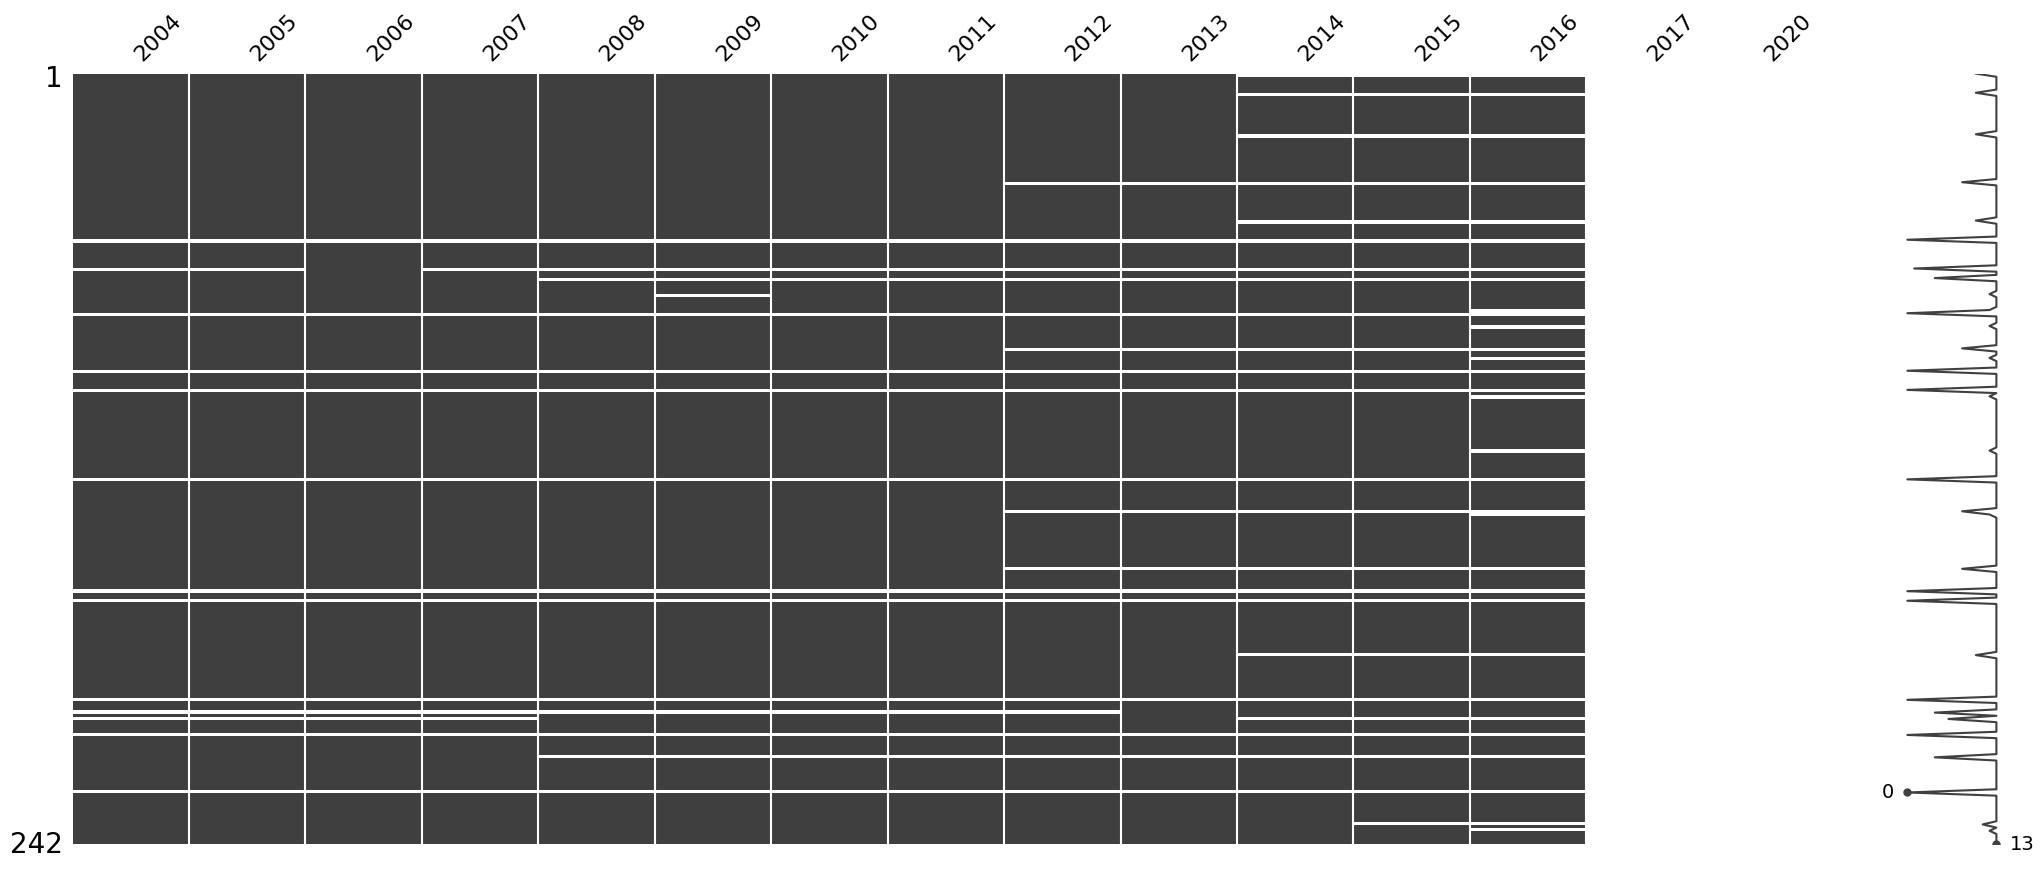

In [28]:
msno.matrix(data_pib[years_rec])

On supprime les colonnes des années non étudiées:

In [29]:
data_pib = data_pib.drop(columns=years_out)

In [30]:
# On supprime les lignes avec des valeurs vides:
data_pib = data_pib.dropna()
print("Nombre de pays avec des données complètes pour ces années: %d" % len(data_pib))

Nombre de pays avec des données complètes pour ces années: 217


Repèrage des valeurs non-flotantes ou négatives.

In [31]:
data_pib_wrong = data_pib[years_in].apply(is_float_s)

On vérifie qu'il n'y à pas de valeurs aberrantes.

In [32]:
# Calcul des maximums/minimums pour chaque ligne:
min_pib, max_pib = data_pib[years_in].min(), data_pib[years_in].max()
print("PIB/hab compris dans [%s, %s]" %(min(min_pib), max(max_pib)))

PIB/hab compris dans [127.429664803296, 179308.075615568]


On donne un score entre 0 et 5 pour chaque pays en fonction de son PIB pour chaque année.   
Pour cela, on utilise le rapport avec le plus haut PIB/hab de l'année et on multiplie ce rapport par 5.

In [33]:
data_pib[years_in] = (data_pib[years_in]/max_pib)*5

### III) 3- Internet

In [34]:
# data_pib: Dataframe qui va contenir les données de l'indicateur de l'accès à internet pour les pays étudiés
data_internet = data[data['Indicator Code'] == indic_internet['Series Code']]

Valeurs manquantes:

<AxesSubplot: >

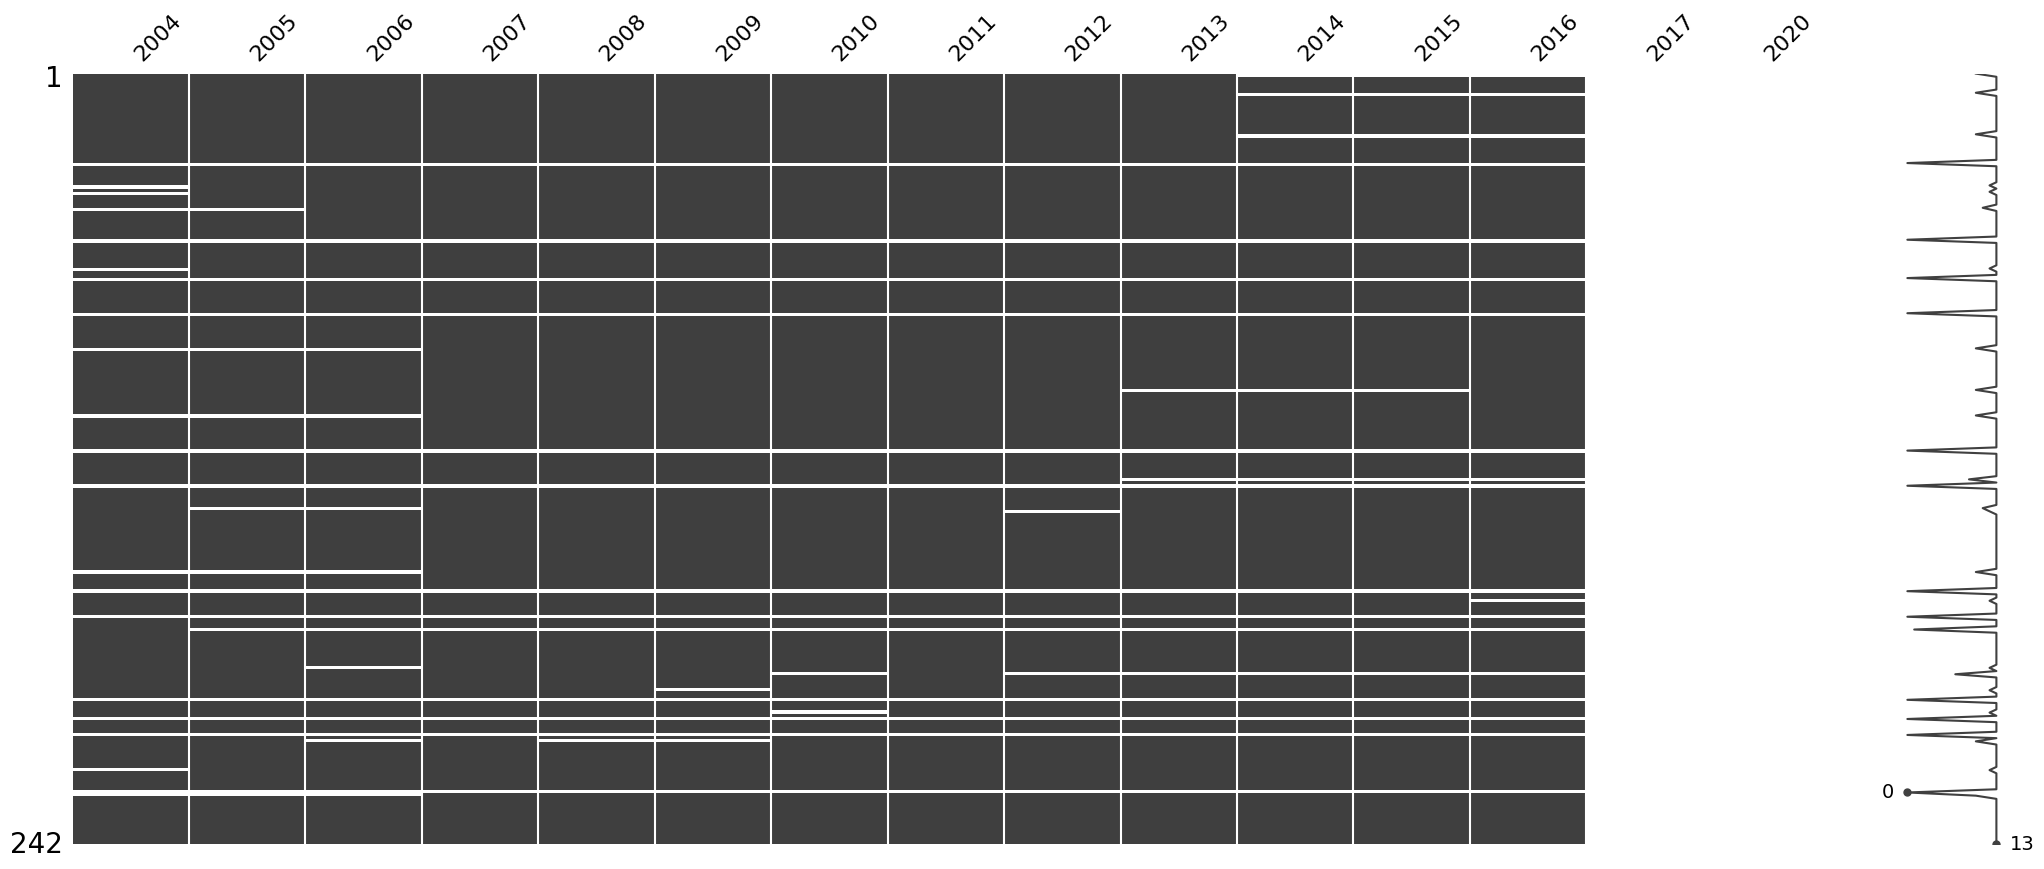

In [35]:
msno.matrix(data_internet[years_rec])

In [36]:
data_internet = data_internet.drop(columns=years_out)

In [37]:
data_internet = data_internet.dropna()
print("Nombre de pays pour lesquels les données sont complètes: %d" % len(data_internet))

Nombre de pays pour lesquels les données sont complètes: 208


Repèrage des valeurs non-flotantes ou négatives.

In [38]:
data_internet_wrong = data_internet[years_in].apply(is_float_s)

In [39]:
data_internet_max, data_internet_min = data_internet[years_in].max(), data_internet[years_in].min()
print("Pourcentage d'accès à internet dans [%s, %s]" % (min(data_internet_min), max(data_internet_max)))

Pourcentage d'accès à internet dans [0.024337392, 98.16]


On divise le pourcentage par 100 pour obtenir un taux, et on le multiplie par 5 pour avoir une note en 0 et 5.

In [40]:
data_internet[years_in] = data_internet[years_in]*5/100

### III) 4- Démographie

In [41]:
data_pop_jeune = data[data['Indicator Code'] == indic_pop_jeune['Series Code']]
data_pop_tot = data[data['Indicator Code'] == indic_pop_tot['Series Code']]

Valeurs manquantes:

<AxesSubplot: >

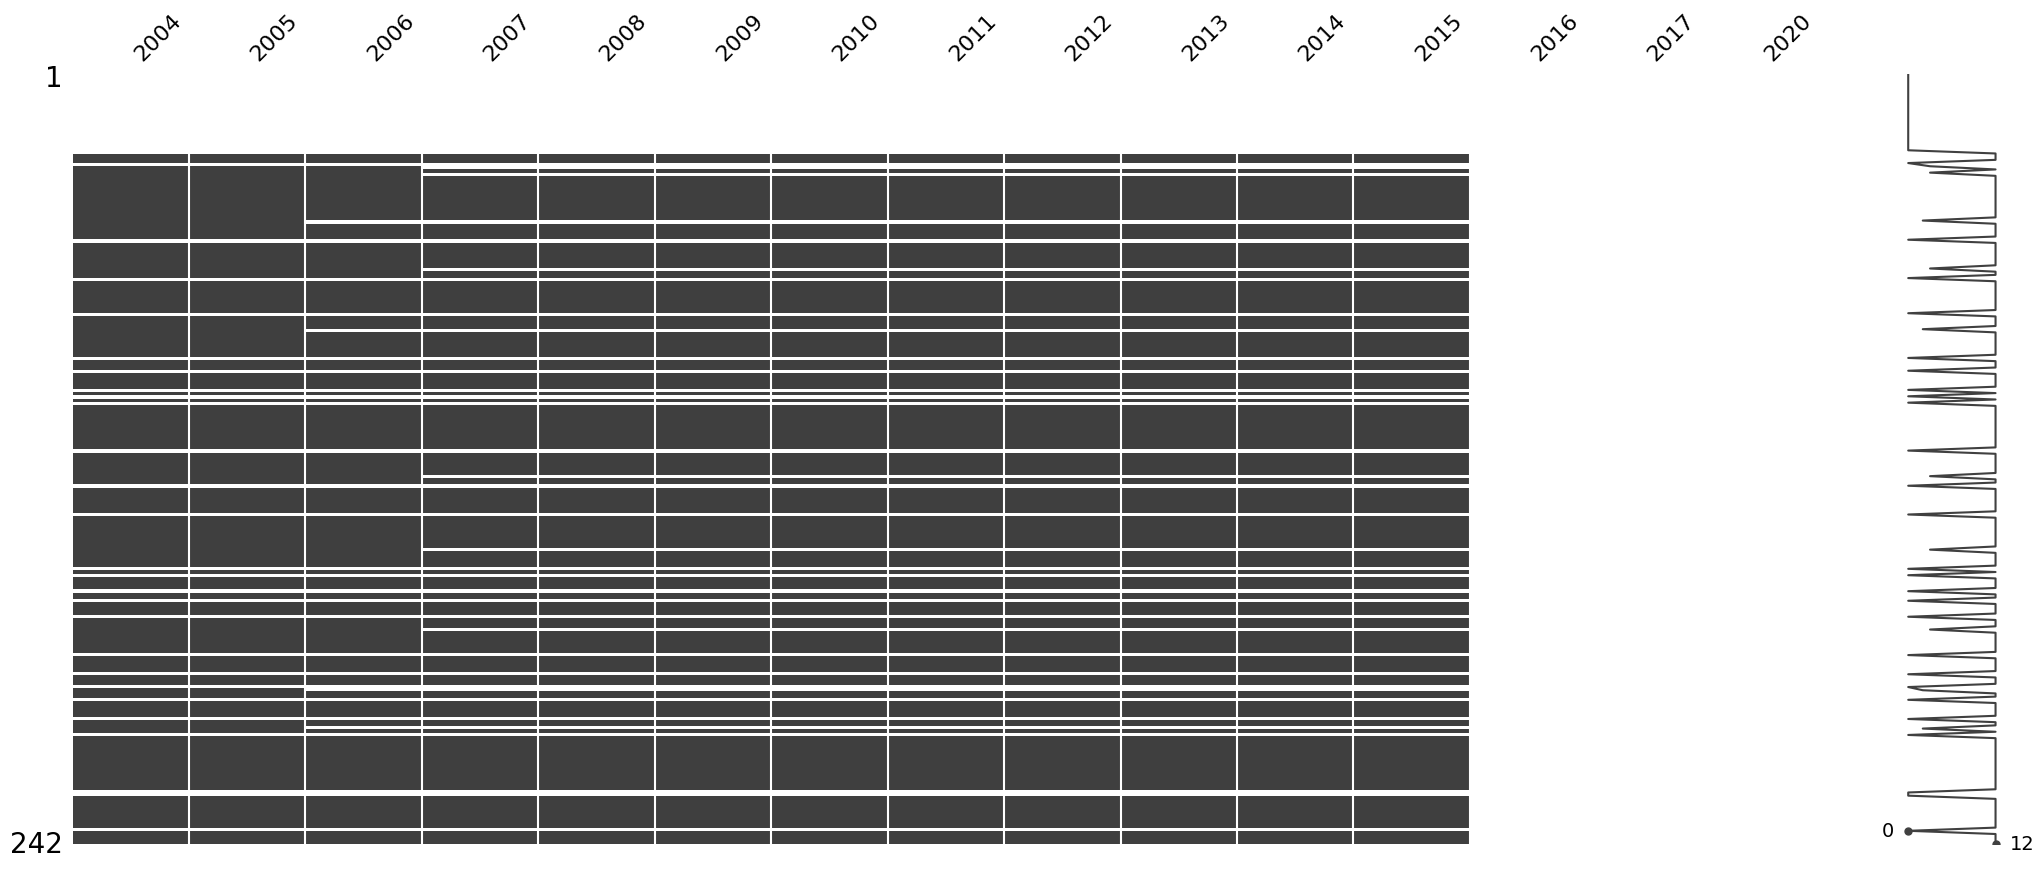

In [42]:
msno.matrix(data_pop_jeune[years_rec])

On supprime les colonnes des années non étudiées dans les données de la population jeune:

In [43]:
data_pop_jeune = data_pop_jeune.drop(columns=years_out)

<AxesSubplot: >

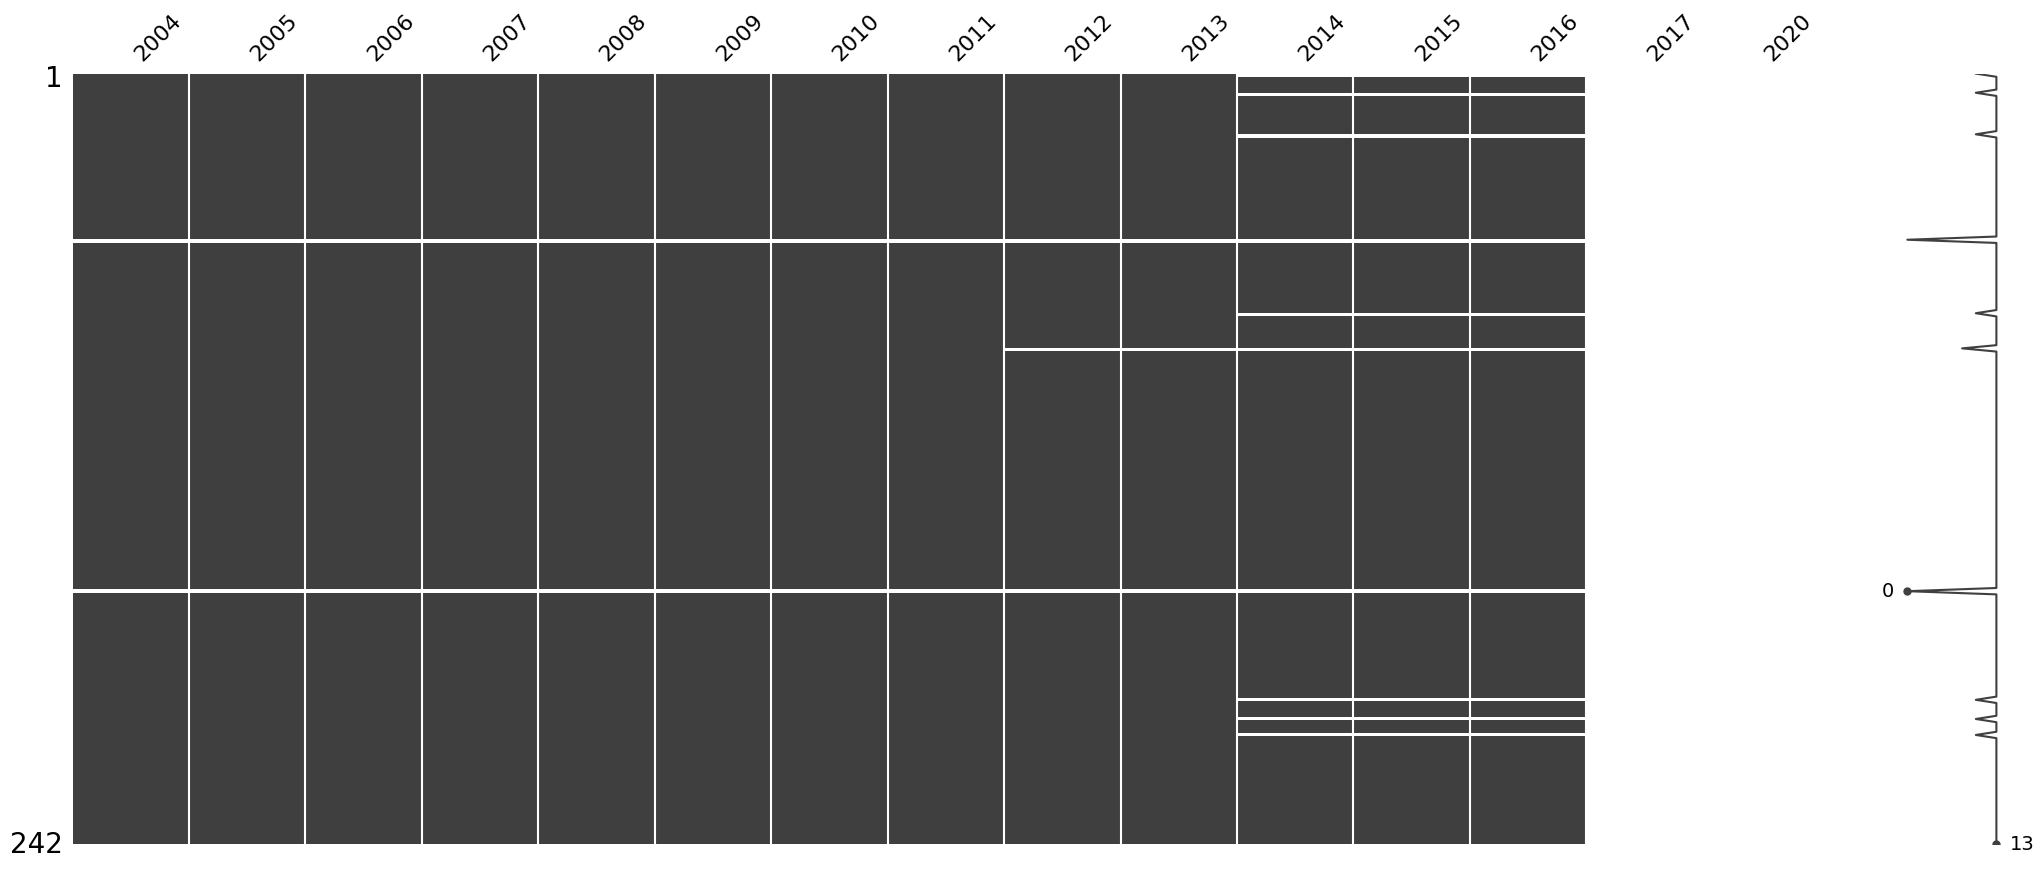

In [44]:
msno.matrix(data_pop_tot[years_rec])

On supprime les colonnes des années non étudiées dans les données de la population totale:

In [45]:
data_pop_tot = data_pop_tot.drop(columns=years_out)

Repérage des valeurs négatives ou non-flottantes:

In [46]:
data_pop_tot_wrong = data_pop_tot[years_in].apply(is_float_s)

In [47]:
data_pop_jeune_wrong = data_pop_jeune[years_in].apply(is_float_s)

In [48]:
# On supprime les lignes contenant des cases vides
data_pop_jeune = data_pop_jeune.dropna()
data_pop_tot = data_pop_tot.dropna()
print("Taille de l'échantillon pour la population jeune: %d" % len(data_pop_jeune))
print("Taille de l'échantillon pour la population totale: %d" % len(data_pop_tot))

Taille de l'échantillon pour la population jeune: 181
Taille de l'échantillon pour la population totale: 232


On calcule le rapport entre la population jeune et la population totale

In [49]:
# countries: Series des pays qui ont recensé à la fois la population totale et la population jeune
countries = pd.merge(data_pop_jeune['Country Code'], data_pop_tot['Country Code'], on='Country Code')

In [50]:
# On renstreint les dataframes data_pop_tot et data_pop_jeune aux pays qui ont renseignés les deux indicateurs.
# Pour data_pop_jeune, on met le résultat dans data_pop, en prévision du rapport à réaliser.
data_pop = data_pop_jeune[data_pop_jeune['Country Code'].isin(countries['Country Code'])]
data_pop_tot_ = data_pop_tot[data_pop_tot['Country Code'].isin(countries['Country Code'])]
data_pop.index = data_pop_tot_.index  # On synchronise les index des deux tables dont on va calculer le rapport

In [51]:
print("Taille de l\'échantillon final pour la population: %d" % len(data_pop))

Taille de l'échantillon final pour la population: 180


In [52]:
# Calcul du taux de la population entre 24 et 35 ans pour chaque pays et chaque année.
data_pop[years_in] = data_pop[years_in]/data_pop_tot_[years_in]

/tmp/ipykernel_16738/287325952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pop[years_in] = data_pop[years_in]/data_pop_tot_[years_in]


Pour avoir une note entre 0 et 5, on multiplie le taux par 5. Pour que la note maximale soit atteinte, on normalise les valeurs obtenues en prenant le rapport avec la valeur maximale pour chaque année.

In [53]:
data_pop_max = data_pop[years_in].max()
data_pop_min = data_pop[years_in].min()
print("Rapport compris entre %s et %s" % (min(data_pop_min), max(data_pop_max)))

Rapport compris entre 0.05354236131028264 et 0.2746438546082903


In [54]:
data_pop[years_in] = data_pop[years_in]/data_pop_max

/tmp/ipykernel_16738/4019329236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pop[years_in] = data_pop[years_in]/data_pop_max


In [55]:
data_pop[years_in] = data_pop[years_in]*5

/tmp/ipykernel_16738/2748572826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pop[years_in] = data_pop[years_in]*5


### III) 5- Croisement des échantillons

Calcul des pays renseignant les valeurs des indicateurs dans les dataframes des 4 indicateurs.

In [56]:
countries = pd.merge(countries['Country Code'], data_internet['Country Code'], on='Country Code')

In [57]:
countries = pd.merge(countries['Country Code'], data_pib['Country Code'], on='Country Code')

In [58]:
countries = pd.merge(countries['Country Code'], data_educ['Country Code'], on='Country Code')

In [59]:
print("L'étude porte sur %d pays" % len(countries))

L'étude porte sur 119 pays


On restreint les dataframes à ces pays:

In [60]:
data_internet = data_internet[data_internet['Country Code'].isin(countries['Country Code'])]
data_pib = data_pib[data_pib['Country Code'].isin(countries['Country Code'])]
data_educ = data_educ[data_educ['Country Code'].isin(countries['Country Code'])]
data_pop = data_pop[data_pop['Country Code'].isin(countries['Country Code'])]

**Calcul du score sur 20**

In [61]:
# score: Va contenir pour chaque pays/année son score sur 20
score = data_internet.copy()   # score va avoir le même format que data_internet
score = score.drop(columns=['Indicator Name', 'Indicator Code'])  # Ces colonnes n'ont plus de sens pour score

Pour faire la somme des scores/5, il faut que les indices soient les mêmes d'une table à l'autre. On sait que les pays sont dans le même ordre.

In [62]:
data_internet.index = score.index
data_pib.index = score.index
data_educ.index = score.index
data_pop.index = score.index

On vérifie que lorsque les indices correspondent, les pays correspondent aussi.

In [63]:
print(data_pib[(data_pib.index == score.index) & (data_pib['Country Name'] != score['Country Name'])])
print(data_educ[(data_educ.index == score.index) & (data_educ['Country Name'] != score['Country Name'])])
print(data_pop[(data_pop.index == score.index) & (data_pop['Country Name'] != score['Country Name'])])

Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Index: []
Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Index: []
Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
Index: []


**Étude des corrélation entre les indicateurs**   
La mise en évidence de corrélations entre les indicateurs pourrait nous permettre de nous affranchir de certains indicateurs.   
Pour l'année 2014, on va observer le coefficient de corrélation pour les tous les couples d'indicateurs. Si celui-ci dépasse 0.8, on étudiera plus précisemment cette corrélation.

In [64]:
data_educ['2014'].corr(data_pib['2014'], method="pearson")

0.5395607136960479

In [65]:
data_educ['2014'].corr(data_pop['2014'], method="pearson")

-0.6700420868019136

In [66]:
data_educ['2014'].corr(data_internet['2014'], method="pearson")

0.8105866777128372

**Correlation entre le taux de scolarisation et l'accès à internet**   

coefficient de corrélation: 0.8105866777128372


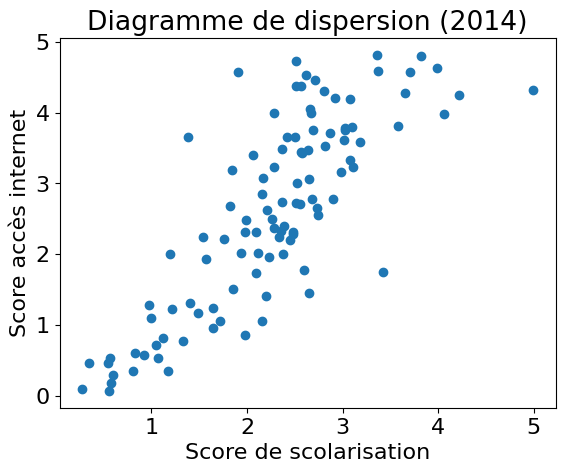

In [67]:
year = '2014'
print("coefficient de corrélation: %s" % data_educ[year].corr(data_internet[year], method="pearson"))
plt.rc('font', size=16)
plt.title('Diagramme de dispersion (%s)' % year)
plt.xlabel('Score de scolarisation')
plt.ylabel('Score accès internet')
plt.scatter(data_educ[year], data_internet[year])

Malgré le coefficient de Pearson plus tôt élevé, on observe plutôt une tendance polynomiale: La courbe est plus applatit autour de l'origine et autour des scores élevés.
On peut observer ce qui se passe pour une autre année pour voir ce qu'il en est:

coefficient de corrélation: 0.7063016997456288


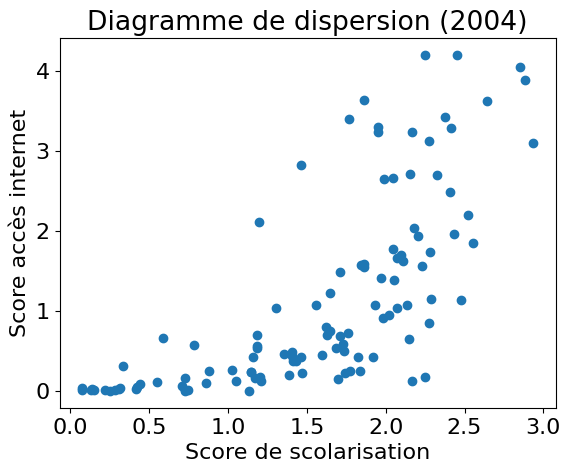

In [68]:
year='2004'
print("coefficient de corrélation: %s" % data_educ[year].corr(data_internet[year], method="pearson"))
plt.rc('font', size=16)
plt.title('Diagramme de dispersion (%s)' % year)
plt.xlabel('Score de scolarisation')
plt.ylabel('Score accès internet')
plt.scatter(data_educ[year], data_internet[year])

On voit qu'il y à un écart entre le score de scolarisation et celui de l'accès à internet, lorsque la scolarisation est peu développée, et que cet écart se réduit au fur et à mesure que la scolarisation se développe.    
Le coefficient de Pearson élevé pour le diagramme de 2014 s'explique par le fait que la courbe est peu applatie, car la plus part des pays on un meilleur score de scolarisation. La courbe est donc plus facilement approximable par une droite.   
En conclusion: On ne pourra pas substituer ces 2 indicateurs par l'un d'entre eux.

In [69]:
data_pib['2014'].corr(data_pop['2014'], method="pearson")

-0.6381278882216112

In [70]:
data_pib['2014'].corr(data_internet['2014'], method="pearson")

0.7450811906536475

In [71]:
data_pib['2014'].corr(data_pop['2014'], method="pearson")

-0.6381278882216112

On n'a pu enlever aucun indicateur, on calcule donc la somme de tous les scores sur 5.

In [72]:
# Calcul de la somme des scores/5
score[years_in] = (data_internet[years_in] + data_pib[years_in] + data_educ[years_in] + data_pop[years_in])

## IV) Indicateurs classiques par pays

Calcule de l'écart-type pour chaque pays:

In [73]:
score['Standar deviation'] = score[years_in].std(axis=1)

In [74]:
score['Median'] = score[years_in].median(axis=1)

Pour la moyenne, on commence par enlever les outliers des scores car elle n'est pas robuste à ceux-ci.

In [75]:
# On cacule les 1er et 3ème quartiles pour chaque pays, ainsi que l'écart inter-quartile
Q1 = score[years_in].quantile(q=.25, axis=1)  # 1er quartile
Q3 = score[years_in].quantile(q=.75, axis=1)  # 3ème quartile
IQR=Q3-Q1  # Écart inter-quartile
# mean: Fonction retournant la moyenne du score d'un pays en prenant son indice, sans prendre en compte les outliers
def mean(i):
    score_c = score.loc[i][years_in]
    score_no_outliers = score_c[~((score_c < (Q1.loc[i]-1.5*IQR.loc[i])) | (score_c> (Q3.loc[i]+1.5*IQR.loc[i])))]
    return score_no_outliers.mean()
score['Mean'] = score.index.map(mean)

### VI) 1- Pays avec le plus fort potentiel

In [76]:
score = score.sort_values('Mean', axis=0, ascending=False)
score.iloc[:10][['Country Name', 'Mean', 'Median', 'Standar deviation']]

,Country Name,Mean,Median,Standar deviation
628090,Norway,13.917501,13.932526,0.780389
514475,Luxembourg,12.945753,12.901924,0.744648
287245,Denmark,12.559033,12.547185,0.536906
411855,Iceland,12.450190,12.435768,0.528735
602435,Netherlands,12.080895,12.045138,0.762123
778355,Sweden,12.023910,11.918853,0.615509
430180,Ireland,11.900078,11.879394,0.890420
609765,New Zealand,11.878538,11.827102,0.791154
334890,Finland,11.875559,11.929857,0.855302
782020,Switzerland,11.602113,11.630625,0.659306


Text(0.5, 0, 'Pays')

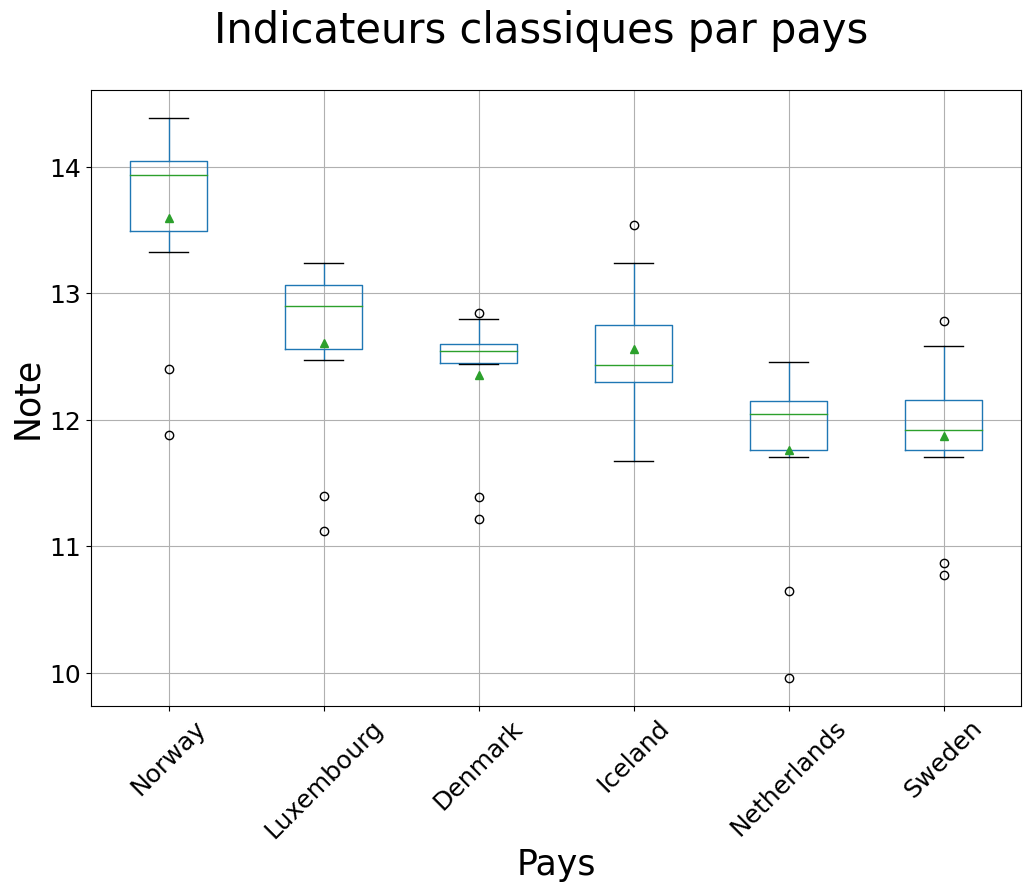

In [77]:
# index: Va contenir les colonnes des années étudiées et 'Country Name'
index = years_in.append(pd.Index(['Country Name']))
# df: Va contenir une colonne par pays, contenant les valeurs des indicateurs pour chaque année
df = score[years_in].iloc[:6].T
df.columns = score['Country Name'].iloc[:6]
plt.rc('font', size=25)
axes = df.boxplot(showmeans=True, rot=45, figsize=(12,8), fontsize=18)
fig = axes.get_figure()
fig.suptitle("Indicateurs classiques par pays")
plt.ylabel('Note')
plt.xlabel('Pays')

On remarque que pour quasiment tous les pays, il y à des outliers avec des notes plus basses. En regardans les courbes des notes, on voit qu'il s'agit des notes des années les plus anciennes.

### IV) 2- Évolution du potentiel

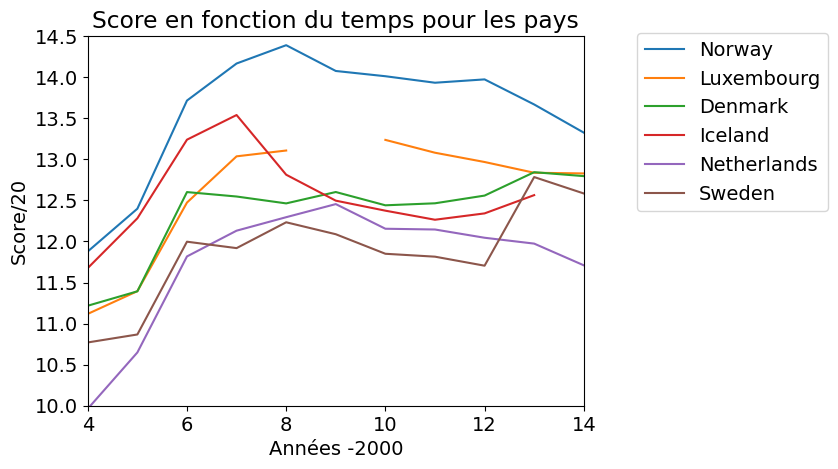

In [78]:
# years_plt: Contient les années étudiée castées en entiers -2000
years_plt = [int(i)-2000 for i in years_in]
plt.rc('font', size=14)
plt.figure()
# ind: Indice du pays dont on affiche la courbe des scores
for ind in score.index[:6]:
    plt.plot(years_plt, score.loc[ind][years_in], label=score.loc[ind]['Country Name'])
plt.title("Score en fonction du temps pour les pays")
plt.xlabel('Années -2000')
plt.ylabel('Score/20')
plt.axis([4, 14, 10, 14.5])
plt.legend(loc='lower center', bbox_to_anchor=(1.3, 0.5))
plt.show()

**Régression linéaire des courbes des scores**

In [79]:
def coeffs_country(score, country, years):
    """Retourne les coefficients et le petit p de la régression linéaire de la courbe des scores"""
    # On commence par se débarasser des nan
    y = score[score['Country Name'] == country][years].iloc[0].to_numpy()
    available_value = np.logical_not(np.isnan(y))
    x = years.to_numpy()
    x = x[available_value]
    y = y[available_value]
    x = x.astype(int)  # Car les années étaient sous forme de str
    x = x.reshape((len(x), 1))
    x = sm.add_constant(x)
    # Régression linéaire avec statsmodels
    reg = sm.OLS(y, x)
    res = reg.fit()
    return res.params[0], res.params[1], res.pvalues[1]

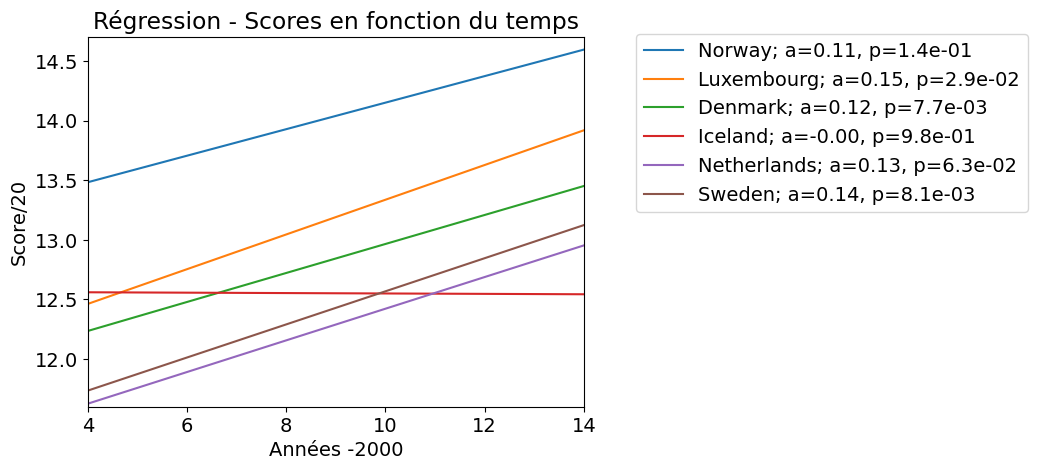

In [80]:
plt.figure()
# ind: Indice du pays dont on affiche la régression linéaire du score
for ind in score.index[:6]:
    country_name = score.loc[ind]['Country Name']
    b, a, r2 = coeffs_country(score, country_name, years_in)
    plt.plot(years_plt, [a*int(year+2004)+b for year in years_plt], label=country_name+"; a=%.2f, p=%.1e" % (a, r2))
plt.rc('font', size=14)
plt.title("Régression - Scores en fonction du temps")
plt.xlabel('Années -2000')
plt.ylabel('Score/20')
plt.axis([4, 14, 11.6, 14.7])
plt.legend(loc='lower center', bbox_to_anchor=(1.5, 0.5))
plt.show()

La plus part des régressions linéaires ne sont pas proches de leurs courbes d'origine (à part celle du Danemark et de la Suède). En effet, on voit que les courbes sont plus proches d'un morceau de sinusoïde que d'une droite.

**Taux de croissance moyen des notes**

In [81]:
# index: Va contenir les colonnes '2004' et '2014'
index = years_in[:1].append(years_in[-1:])
# score_growth: Va contenir le taux de croissance entre 2004 et 2014 dans la colonne '2014'
score_growth = score[index].T.pct_change().T
score_growth = score_growth.drop(columns=['2004'])
def mean_rate(glob_rate):
    """Calcule un taux de croissance moyen à partir d'un taux de croissance sur plusieurs années"""
    return pow(glob_rate+1, 1/(len(years_in)-1))-1
score_growth['Mean growth'] = score_growth['2014'].apply(mean_rate)
score_growth = score_growth.drop(columns=['2014'])
score_growth['Country Name'] = score['Country Name']
score_growth.iloc[:6]

,Mean growth,Country Name
628090,0.011558,Norway
514475,0.014409,Luxembourg
287245,0.013248,Denmark
411855,0.000000,Iceland
602435,0.016281,Netherlands
778355,0.015686,Sweden


Les taux de croissance moyens ont des valeurs proches des pentes des régressions linéaires calculées précédemment.

### Analyse des données prospectives

Pour l'étude prospective, on s'intéresse aux 6 pays au plus fort potentiel.

In [82]:
# countries_in: Pays dans l'étude prospective.
countries_in = score.iloc[:6]['Country Name']

On ajoute la colonne 'Mean sample size 2' pour la taille moyenne des échantillons par indicateur dans series pour les années 2025-2100.

In [83]:
# index: Index contenant les colonnes des années étudiées et le code indicateur
index = years_proj.append(pd.Index(['Indicator Code']))
# indic_mean: Va contenir le nombre moyen de pays dont on a la valeur par indicateur. La moyenne est calculée sur
# les années étudiées.
indic_mean = data[index].groupby('Indicator Code').count().mean(axis=1)
indic_mean = indic_mean.rename("Mean sample size 2")
indic_mean = indic_mean.to_frame()
# On ajoute la colonne 'Mean sample size' à series, pour ajouter cette donnée pour choisir les indicateurs.
series = pd.merge(series, indic_mean, right_index=True, left_on='Series Code')  # Ajout de la colonne créée à series

On vérifie si on a les données pour les indicateurs choisis.

In [84]:
series[series['Indicator Name'] == indic_educ['Indicator Name']][['Indicator Name', 'Mean sample size 2']]

,Indicator Name,Mean sample size 2
2313,"gross enrolment ratio, upper secondary, both s...",0.0


In [85]:
series[series['Indicator Name'] == indic_internet['Indicator Name']][['Indicator Name', 'Mean sample size 2']]

,Indicator Name,Mean sample size 2
611,internet users (per 100 people),0.0


In [86]:
series[series['Indicator Name'] == indic_pop_jeune['Indicator Name']][['Indicator Name', 'Mean sample size 2']]

,Indicator Name,Mean sample size 2
2506,"population, ages 15-24, total",0.0


In [87]:
series[series['Indicator Name'] == indic_pib['Indicator Name']][['Indicator Name', 'Mean sample size 2']]

,Indicator Name,Mean sample size 2
1662,gdp per capita (current us$),0.0


On aucune donnée projective pour les indicateurs de l'étude rétrospective. On va donc chercher des indicateurs semblables.

In [88]:
# indics_educ: Va contenir les lignes de series dont les indicateurs contiennent les mots clés intéressants. 
indics_educ = series
indics_educ = indics_educ[indics_educ['Indicator Name'].str.contains('20')]
indics_educ = indics_educ[indics_educ['Indicator Name'].str.contains('mean years of schooling')]
indics_educ = indics_educ[indics_educ['Indicator Name'].str.contains('total')]

#print("Indicateurs potentiels:\n%s\n" \
#      % indics_educ[['Indicator Name', 'Mean sample size']].sort_values('Mean sample size', ascending=False))
#indic_educ: Ligne de series qui contient l'indicateur choisi
indic_educ_p = indics_educ.loc[1899]
print("Indicateur choisi:\n%s" % indic_educ_p[['Indicator Name', 'Mean sample size 2']])
data_educ_p = data[data['Indicator Code'] == indic_educ_p['Series Code']]

Indicateur choisi:
Indicator Name        projection: mean years of schooling. age 20-39...
Mean sample size 2                                                167.0
Name: 1899, dtype: object


Pour étudier la scolarité, on regarde donc la durée moyenne de scolarisation.

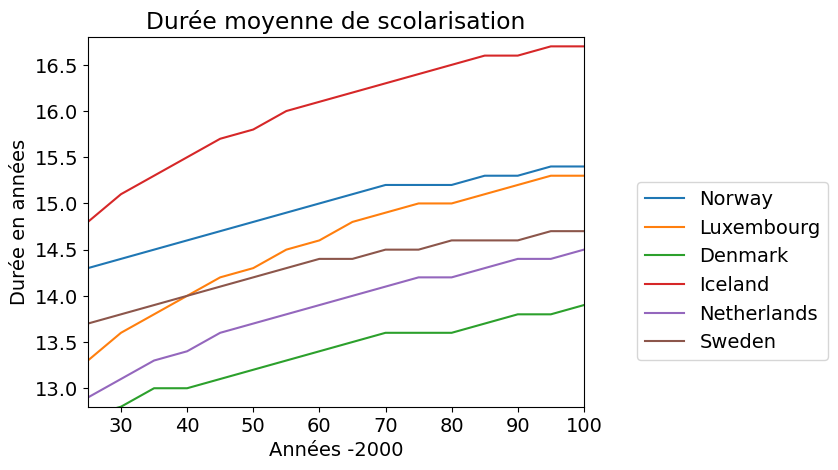

In [89]:
# years_plt: Années supérieures à 2020 auxquelles on soustrait 2000 
years_plt = [int(i)-2000 for i in years_proj]
plt.rc('font', size=14)
plt.figure()
# ind: Indice du pays dont on affiche la courbe de la durée de scolarisation moyenne
for ind in score.index[:6]:
    country_name = score.loc[ind]['Country Name']
    data_country = data_educ_p[data_educ_p['Country Name'] == country_name].iloc[0][years_proj]
    plt.plot(years_plt, data_country, label=country_name)
plt.title("Durée moyenne de scolarisation")
plt.xlabel('Années -2000')
plt.ylabel('Durée en années')
plt.axis([25, 100, 12.8, 16.8])
plt.legend(loc='lower center', bbox_to_anchor=(1.3, 0.1))
plt.show()

Les courbes sont proches de droites. On réalise des régressions linéaires pour préciser les tendances.

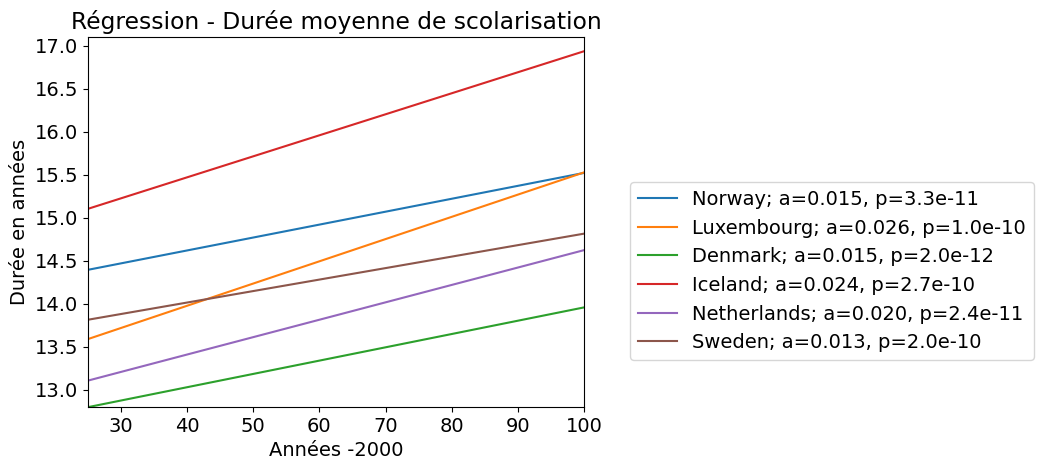

In [90]:
plt.figure()
# ind: Indice du pays dont on affiche la régression linéaire de la durée de scolarisation moyenne
for ind in score.index[:6]:
    country_name = score.loc[ind]['Country Name']
    b, a, r2 = coeffs_country(data_educ_p, country_name, years_proj)
    plt.plot(years_plt, [a*int(year+2000)+b for year in years_plt], label=country_name+"; a=%.3f, p=%.1e" % (a, r2))
plt.rc('font', size=14)
plt.title("Régression - Durée moyenne de scolarisation")
plt.xlabel('Années -2000')
plt.ylabel('Durée en années')
plt.axis([25, 100, 12.8, 17.1])
plt.legend(loc='lower center', bbox_to_anchor=(1.5, 0.1))
plt.show()

### Pays dans lesquels investir en priorité   
Ces pays doivents être parmi les premiers, **que ce soit en termes d'attractivité présente que future**.  

À défaut de pouvoir établir un score pour l'étude prospective comparable à celui de l'étude rétrospective, on va attribuer des points aux pays en fonction de leurs classements pour le score moyen, le taux de croissance moyen, la durée moyenne de scolarisation future et la croissance démographique future.   

On attribut 3 points à la 1ère position, 2 points à la 2ème et 1 point à la 3ème

On  ne retient pour le classement final que les pays qui sont dans le podium du score moyen, et qui sont au moins sur un autre podium.

**Score moyen**    
1- Norway    
2- Luxembourg   
3- Denmark   

**Taux de croissance**    
1- Netherlands    
2- Sweden   
3- Luxembourg

**Durée de scolarisation**    
1- Luxembourg    
2- Iceland    
3- Netherlands    

**Démographie**   
1- Luxembourg   
2- Norway   
3- Sweden

### Scores de priorité
Luxembourg : 14   
Norway : 5    
Denmark : 1

## V) Indicateurs classiques par région

In [91]:
score = pd.merge(score, country[['Region', 'Country Code']], on='Country Code')

In [92]:
def boxplot_region(score, region):
    df = score[score['Region'] == region]
    print("Effectif: %d" % len(df))
    plt.rc('font', size=20)
    axes = df.boxplot(fontsize=14, figsize=(12, 6), showmeans=True)
    fig = axes.get_figure()
    fig.suptitle(region)
    plt.xlabel('Année')
    plt.ylabel('Note')

In [93]:
index = years_in.append(pd.Index(['Region']))
regions = score['Region'].unique()

Effectif: 41


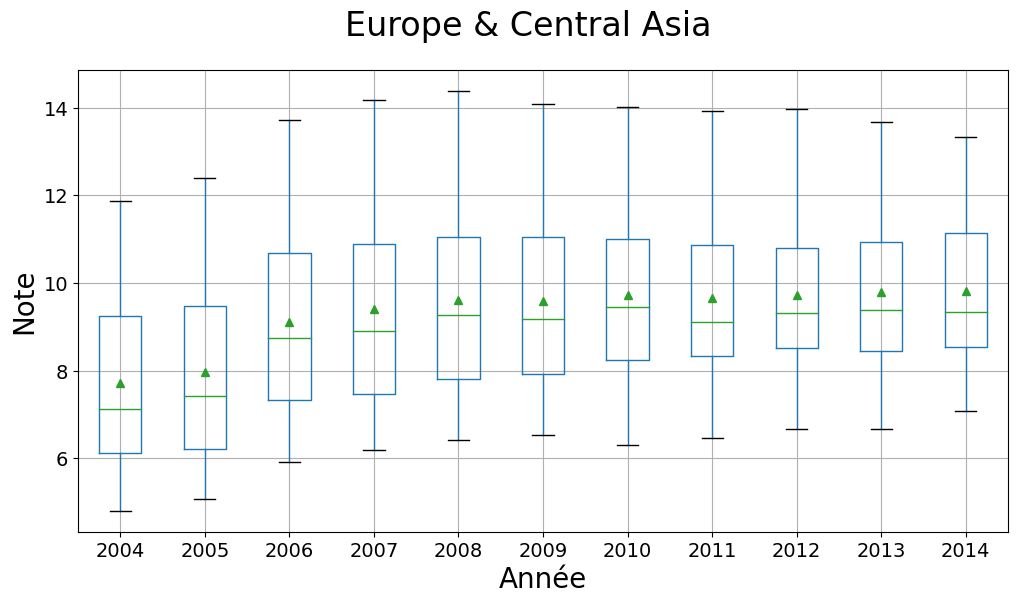

In [94]:
boxplot_region(score[index], regions[0])

On remarque ici que les écarts entre les pays tendent à rétrécir en europe et en asie centrale, et que le valeurs centrales augmentent (environ 7 en 2004 et environ 9 en 2014)

Effectif: 13


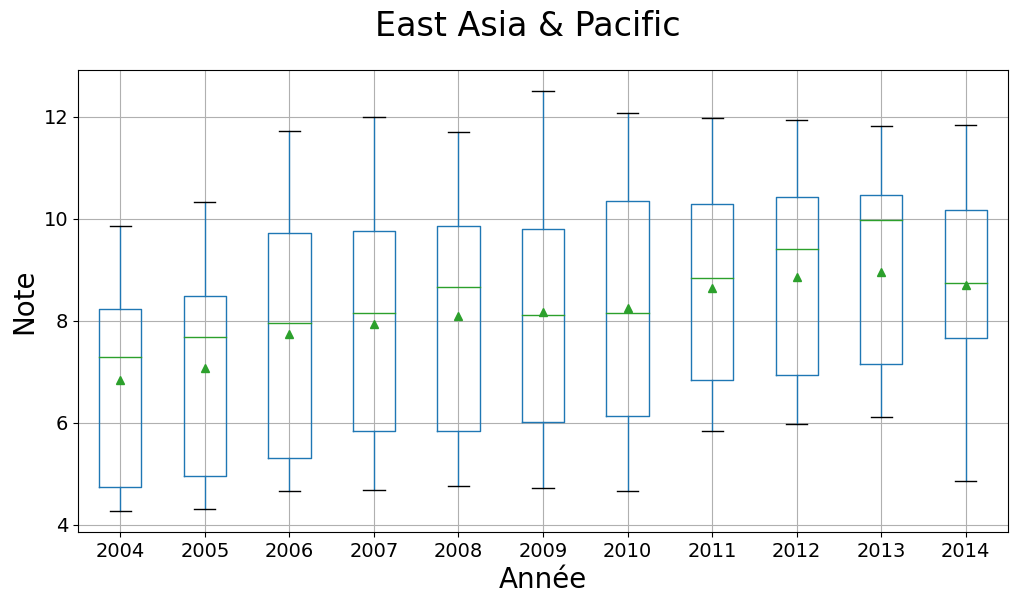

In [95]:
boxplot_region(score[index], regions[1])

Les notes moyennes et médianes augmentent au cours du temps, mais les écarts aux extrémités sont assez conséquents et irréguliers.

In [96]:
print("Pays en Amérique du Nord dans l'étude:")
print(score[score['Region'] == 'North America']['Country Name'])

Pays en Amérique du Nord dans l'étude:
10           Canada
14    United States
Name: Country Name, dtype: object


Effectif: 2


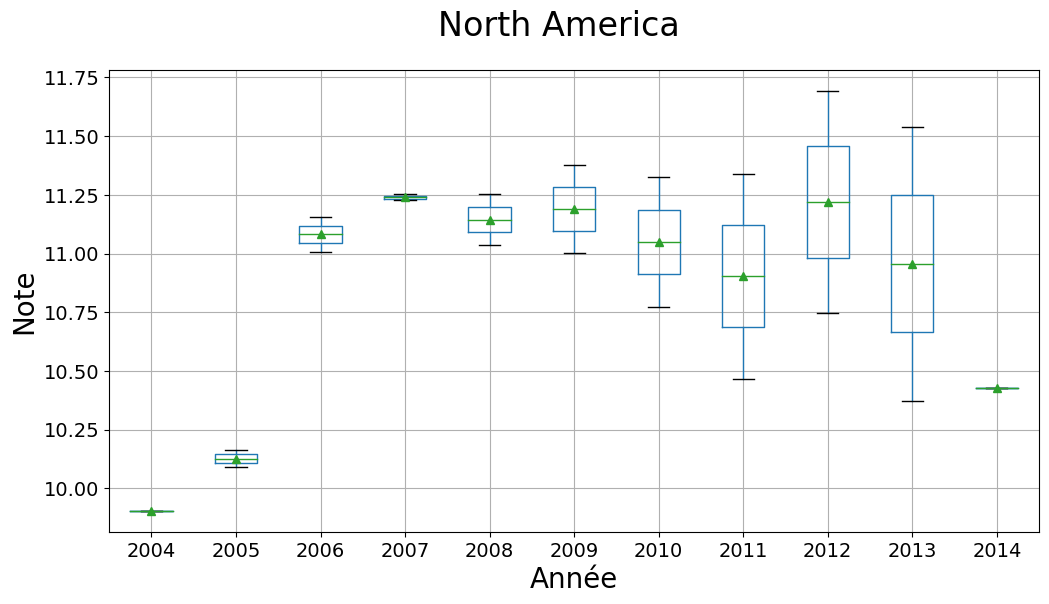

In [97]:
boxplot_region(score[index], regions[2])

Avec un effectif de 2, ce diagramme de Tukey ne permet d'aboutir à aucune conclusion.

Effectif: 14


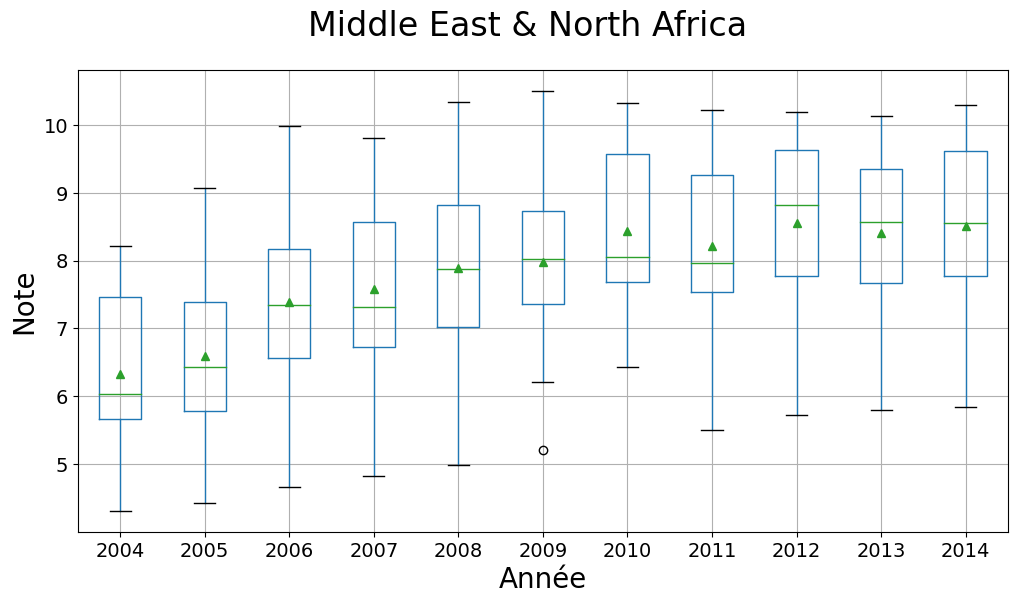

In [98]:
boxplot_region(score[index], regions[3])

Les notes moyennes augmentent d'environ 3 points tandis que les écarts aux extrémités oscillent entre 4 et 5 entre 2004 et 2014.

Effectif: 24


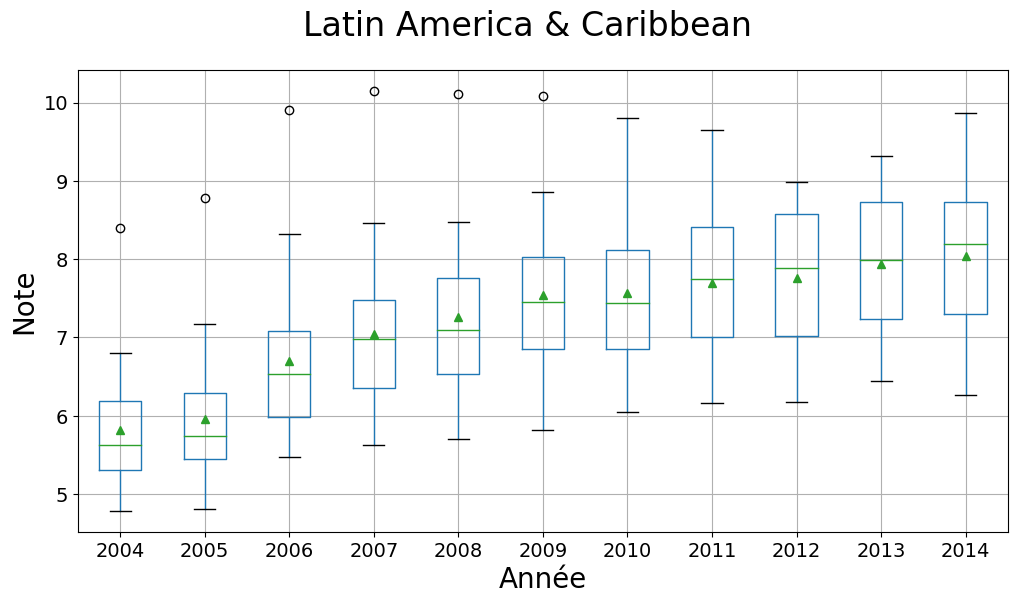

In [99]:
boxplot_region(score[index], regions[4])

On constate une augmentation importante des valeurs centrales, passants de 4.5 en 2004 à 8 environ en 2014.   
L'écart inter-quartile reste quant lui stable, autour de 1.

Effectif: 19


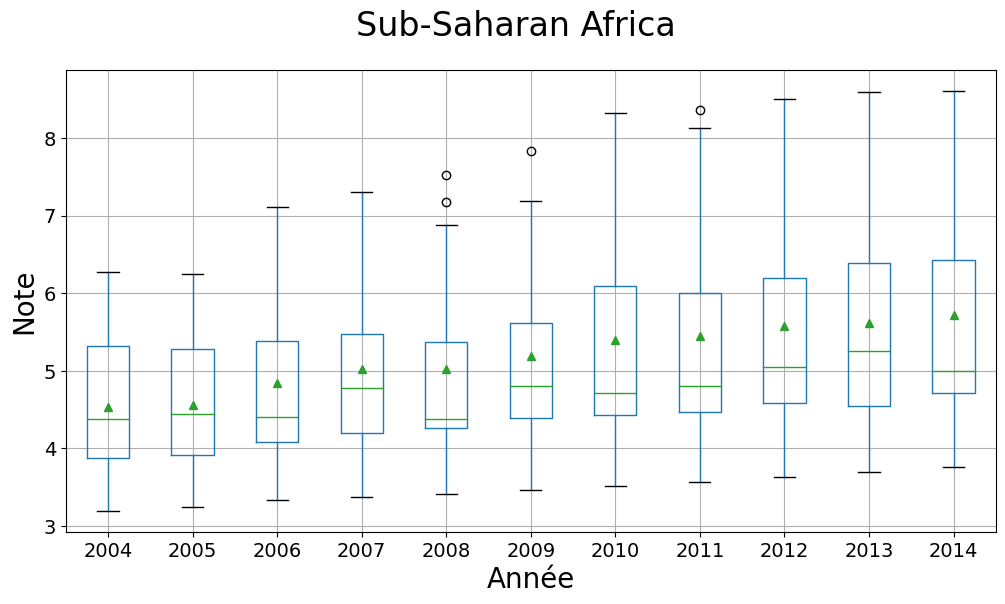

In [100]:
boxplot_region(score[index], regions[5])

On remarque de très grands écarts aux extrémités: Entre 4 et 9 environ en 2014.   
Les notes moyennes et médianes sont égalements parmi les plus basses des régions.

Effectif: 6


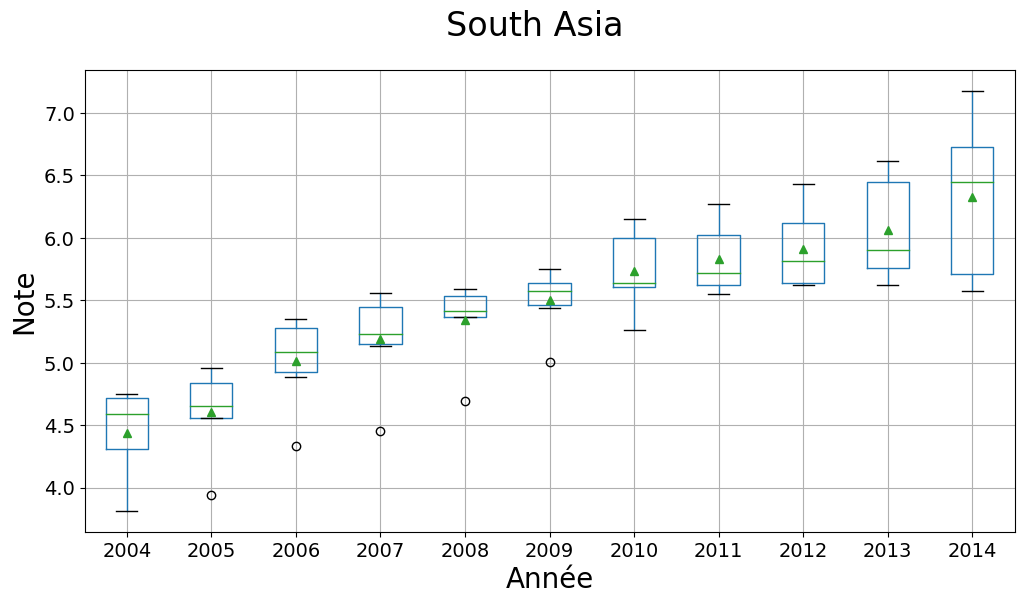

In [101]:
boxplot_region(score[index], regions[6])

De la même manière qye pour les États-Unis, les effectifs sont assez faibles. On remarque cependant que l'écart inter-quartile augmente beaucoup pendant les dernières années. (0.5 en 2012, 1.5 en 2013 et 2 en 2014)

On constate de grandes disparités des scores en fonction des régions.

In [102]:
print("Écart-type des notes par région")
score[index].groupby('Region').std().mean(axis=1).sort_values()

Écart-type des notes par région


Region
North America                 0.343852
South Asia                    0.385965
Latin America & Caribbean     0.941495
Sub-Saharan Africa            1.226545
Middle East & North Africa    1.335373
Europe & Central Asia         1.959742
East Asia & Pacific           2.226464
dtype: float64

Les régions avec l'écart-type moyen le plus bas sont les régions avec le plus petit effectif, sans surprise.   
En revanche, on constante que l'écart-type est plus élevé en asie de l'est et au pacifique qu'en europe et en asie centrale, alors que cette dernière région a un effectif beaucoup plus grand. Cela montre que le score y est plus homogène. 